<center><h1>DNN Model to predict if a business has a validated parking</h1></center>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# import dask.dataframe as dd
from warnings import filterwarnings
filterwarnings('ignore')

### Reading the Train and Test data

In [341]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [342]:
X_train.drop(['city','business_id','review_id','user_id','categories'],axis=1,inplace = True)
X_test.drop(['city','business_id','review_id','user_id','categories'],axis=1,inplace = True)


Dropping unnecessary columns

In [343]:
state_replacement = {
    "PA": "Pennsylvania",
    "FL": "Florida",
    "LA": "Louisiana",
    "TN": "Tennessee",
    "MO": "Missouri",
    "IN": "Indiana",
    "AZ": "Arizona",
    "NV": "Nevada",
    "CA": "California",
    "NJ": "New Jersey",
    "ID": "Idaho",
    "AB": "Alberta",
    "DE": "Delaware",
    "IL": "Illinois",
    "TX": "Texas",
    "SD": "South Dakota"
}

X_train['state'] = X_train['state'].replace(state_replacement)

X_test['state'] = X_test['state'].replace(state_replacement)


Replacing the abbreviation of states with the complete names

In [344]:
indices_to_drop = X_train[X_train['state'].isin(['South Dakota', 'Texas'])].index
X_train = X_train.drop(indices_to_drop)
y_train = y_train.drop(indices_to_drop)


In [345]:
indices_to_drop = X_test[X_test['state'].isin(['South Dakota', 'Texas'])].index
X_test = X_test.drop(indices_to_drop)
y_test = y_test.drop(indices_to_drop)

Dropping low occurring state data points

In [346]:
X_train.iloc[0]

state                         Pennsylvania
business_stars                         4.0
business_review_count                  492
is_open                                  1
BusinessAcceptsCreditCards               1
restaurant_price_level                   2
BikeParking                           True
parking_garage                           0
parking_street                           0
lot_parking                              1
valet_parking                            0
review_stars                             5
review_useful                            0
review_funny                             0
review_cool                              0
user_review_count                     14.0
user_average_stars                    3.73
checkin_review_count                1052.0
Name: 0, dtype: object

In [347]:
X_train.business_stars = X_train.business_stars.astype(str)
X_test.business_stars = X_test.business_stars.astype(str)

X_test.business_stars.info()

<class 'pandas.core.series.Series'>
Index: 1115708 entries, 0 to 1115720
Series name: business_stars
Non-Null Count    Dtype 
--------------    ----- 
1115708 non-null  object
dtypes: object(1)
memory usage: 17.0+ MB


In [348]:
# X_train.is_open = X_train.is_open.astype(str)
# X_test.is_open = X_test.is_open.astype(str)

# X_train.BusinessAcceptsCreditCards = X_train.BusinessAcceptsCreditCards.astype(str)
# X_test.BusinessAcceptsCreditCards = X_test.BusinessAcceptsCreditCards.astype(str)

# X_train.restaurant_price_level = X_train.restaurant_price_level.astype(str)
# X_test.restaurant_price_level = X_test.restaurant_price_level.astype(str)

X_train.BikeParking.replace({True:1,False:0},inplace = True)
X_test.BikeParking.replace({True:1,False:0},inplace = True)

Encoding this categorical feature

In [349]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4462836, 18)
X_test shape: (1115708, 18)
y_train shape: (4462836, 1)
y_test shape: (1115708, 1)


#### Sampling the data

For the unbalanced data, we decided to take 50000 data points for class 0 and 50000 data points for class 1. Did this separately for train and test data to prevent data leakage.

In [350]:
y_train.validated_parking.value_counts()

validated_parking
0    4345600
1     117236
Name: count, dtype: int64

In [351]:
class0_indices_sample = random.sample(y_train[y_train['validated_parking'] == 0].index.tolist(),50000)
X_train1 = X_train.loc[class0_indices_sample]
y_train1 = y_train.loc[class0_indices_sample]  

class1_indices_sample = random.sample(y_train[y_train['validated_parking'] == 1].index.tolist(),50000)
X_train2 = X_train.loc[class1_indices_sample]
y_train2 = y_train.loc[class1_indices_sample]  


X_train_sampled = pd.concat([X_train1, X_train2], axis=0)
y_train_sampled = pd.concat([y_train1, y_train2], axis=0)

# Check the shapes after concatenation
X_train_sampled.shape, y_train_sampled.shape

((100000, 18), (100000, 1))

Shape of final training dataset with balanced classes

In [352]:
y_train_sampled.validated_parking.value_counts()

validated_parking
0    50000
1    50000
Name: count, dtype: int64

In [353]:
y_test.validated_parking.value_counts()

validated_parking
0    1086306
1      29402
Name: count, dtype: int64

Initalling tried to balance test data similarly but decided against as test or real world data is never balanced.

In [354]:
# class0_indices_sample = random.sample(y_test[y_test['validated_parking'] == 0].index.tolist(),10000)
# X_test1 = X_test.loc[class0_indices_sample]
# y_test1 = y_test.loc[class0_indices_sample]  

# class1_indices_sample = random.sample(y_test[y_test['validated_parking'] == 1].index.tolist(),10000)
# X_test2 = X_test.loc[class1_indices_sample]
# y_test2 = y_test.loc[class1_indices_sample]  


# X_test_sampled = pd.concat([X_test1, X_test2], axis=0)
# y_test_sampled = pd.concat([y_test1, y_test2], axis=0)

# # Check the shapes after concatenation
# X_test_sampled.shape, y_test_sampled.shape

In [355]:
X_test_sampled, _, y_test_sampled, _ = train_test_split(X_test, y_test, train_size=0.018, random_state=100)

# Now check the new shapes
print(f"Reduced X_test shape: {X_test_sampled.shape}")
print(f"Reduced y_test shape: {y_test_sampled.shape}")

Reduced X_test shape: (20082, 18)
Reduced y_test shape: (20082, 1)


taking a smaller size for the test set.

In [356]:
y_test_sampled.validated_parking.value_counts()

validated_parking
0    19534
1      548
Name: count, dtype: int64

In [357]:
print(f"X_train shape: {X_train_sampled.shape}")
print(f"X_test shape: {X_test_sampled.shape}")
print(f"y_train shape: {y_train_sampled.shape}")
print(f"y_test shape: {y_test_sampled.shape}")

X_train shape: (100000, 18)
X_test shape: (20082, 18)
y_train shape: (100000, 1)
y_test shape: (20082, 1)


In [358]:
X_train_sampled.restaurant_price_level = X_train_sampled.restaurant_price_level.astype(str)
X_test_sampled.restaurant_price_level = X_test_sampled.restaurant_price_level.astype(str)

In [359]:
X_train_sampled.business_stars = X_train_sampled.business_stars.astype('float')
X_test_sampled.business_stars = X_test_sampled.business_stars.astype('float')

#### Scaling & Encoding

In [411]:
X_train_sampled.columns

Index(['state', 'business_stars', 'business_review_count', 'is_open',
       'BusinessAcceptsCreditCards', 'restaurant_price_level', 'BikeParking',
       'parking_garage', 'parking_street', 'lot_parking', 'valet_parking',
       'review_stars', 'review_useful', 'review_funny', 'review_cool',
       'user_review_count', 'user_average_stars', 'checkin_review_count'],
      dtype='object')

In [412]:
to_encode_features = ['state','restaurant_price_level']
to_scale_features = ['business_stars','business_review_count', 'is_open',
       'BusinessAcceptsCreditCards','BikeParking',
       'parking_garage', 'parking_street', 'lot_parking', 'valet_parking','review_stars', 'review_useful', 'review_funny', 'review_cool',
       'user_review_count', 'user_average_stars', 'checkin_review_count']

In [413]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), to_scale_features),
        ('cat', OneHotEncoder(), to_encode_features)
    ])

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
        ])

X_train_processed = pipeline.fit_transform(X_train_sampled)
X_test_processed = pipeline.transform(X_test_sampled)

In [414]:
print(f"Preprocessed X_train shape: {X_train_processed.shape}")
print(f"Preprocessed X_test shape: {X_test_processed.shape}")
print(f"y_train shape: {y_train_sampled.shape}")
print(f"y_test shape: {y_test_sampled.shape}")

Preprocessed X_train shape: (100000, 35)
Preprocessed X_test shape: (20082, 35)
y_train shape: (100000, 1)
y_test shape: (20082, 1)


Data is encoded and scaled on different datasets for data leakage prevention

In [415]:
X_test_processed[0]

array([-1.43788491, -0.59834224,  0.4525536 ,  0.19246606,  0.47474738,
       -0.65927073, -1.16594878,  1.10580965, -0.45061174,  0.11051671,
       -0.0146178 , -0.21952243, -0.24729987,  0.07925   ,  0.07916991,
       -0.47592209,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ])

In [426]:
# Saving feature names for interpretability
scaled_feature_names = to_scale_features

encoded_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(to_encode_features)

# Combine the scaled and encoded feature names into one list
all_feature_names = list(scaled_feature_names) + list(encoded_feature_names)

# Print or use the feature names
print(all_feature_names)
print(len(all_feature_names))

['business_stars', 'business_review_count', 'is_open', 'BusinessAcceptsCreditCards', 'BikeParking', 'parking_garage', 'parking_street', 'lot_parking', 'valet_parking', 'review_stars', 'review_useful', 'review_funny', 'review_cool', 'user_review_count', 'user_average_stars', 'checkin_review_count', 'state_Alberta', 'state_Arizona', 'state_California', 'state_Delaware', 'state_Florida', 'state_Idaho', 'state_Illinois', 'state_Indiana', 'state_Louisiana', 'state_Missouri', 'state_Nevada', 'state_New Jersey', 'state_Pennsylvania', 'state_Tennessee', 'restaurant_price_level_0', 'restaurant_price_level_1', 'restaurant_price_level_2', 'restaurant_price_level_3', 'restaurant_price_level_4']
35


### Modelling

In [416]:
def plot_roc(y_true, y_prob):
    num_classes = y_test_sampled.value_counts().shape[0]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC curve and AUC for each class
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plotting the ROC curve for each class
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (AUC = {roc_auc[i]:0.7f})')

    # Adding the diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Plot settings
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
    plt.legend(loc='lower right')
    plt.show()

In [417]:
input_features = X_train_processed.shape[1]

In [418]:
# Basic DNN model
model1 = Sequential([
    Dense(256, activation='relu', input_shape=(input_features,)),
    # Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model1.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 256)            │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,521 (357.50 KB)

 Trainable params: 91,521 (357.50 KB)

 Non-trainable params: 0 (0.00 B)

In [419]:
history1 = model1.fit(X_train_processed, y_train_sampled, validation_data=(X_test_processed, y_test_sampled), epochs=30, batch_size=64)


Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8471 - loss: 0.3627 - val_accuracy: 0.9250 - val_loss: 0.1922
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9217 - loss: 0.1937 - val_accuracy: 0.9464 - val_loss: 0.1405
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9393 - loss: 0.1468 - val_accuracy: 0.9261 - val_loss: 0.1689
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9468 - loss: 0.1295 - val_accuracy: 0.9572 - val_loss: 0.1152
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9520 - loss: 0.1133 - val_accuracy: 0.9527 - val_loss: 0.1254
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9567 - loss: 0.1047 - val_accuracy: 0.9558 - val_loss: 0.1227
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9587 - loss: 0.0972 - val_accuracy: 0.9598 - val_loss: 0.1022
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9619 - loss: 0.0924 - 

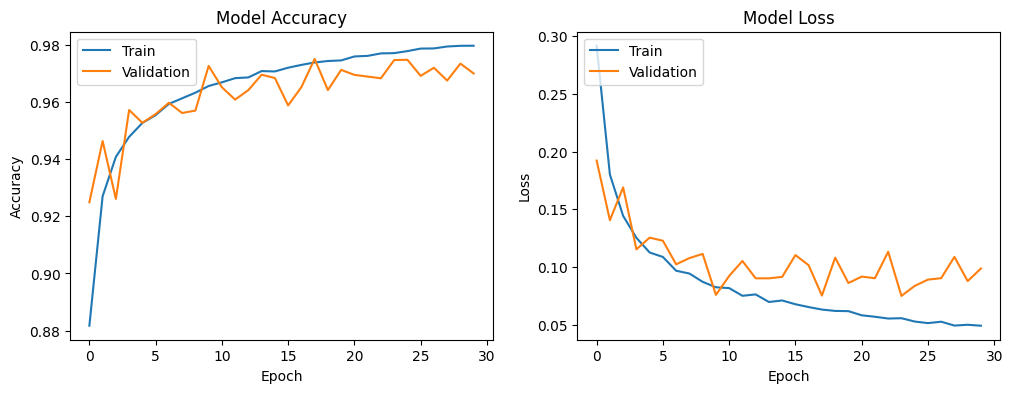

In [420]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     50000
           1       0.98      0.98      0.98     50000

    accuracy                           0.98    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000



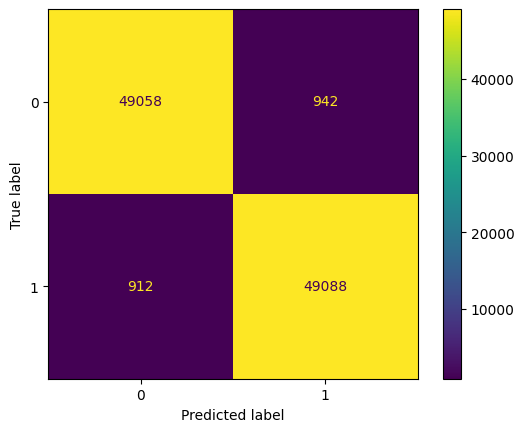

In [421]:
# Training Data Evaluation
ypred_train = model1.predict(X_train_processed) 
y_pred_classes = (ypred_train > 0.5).astype("int32")

print(classification_report(y_train_sampled, y_pred_classes))

ConfusionMatrixDisplay(confusion_matrix(y_train_sampled, y_pred_classes)).plot()


628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     19534
           1       0.48      0.97      0.64       548

    accuracy                           0.97     20082
   macro avg       0.74      0.97      0.81     20082
weighted avg       0.98      0.97      0.97     20082



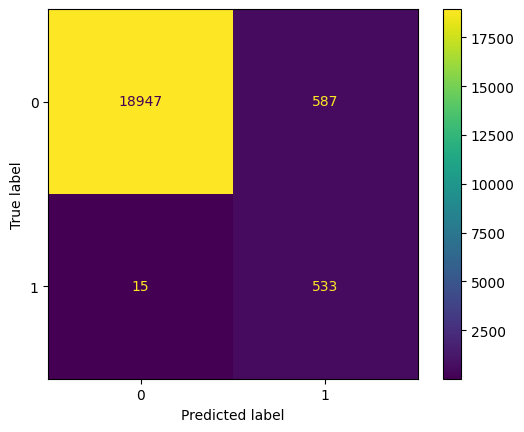

In [422]:
# Testing Data Evaluation

ypred_test = model1.predict(X_test_processed) 
y_pred_classes = (ypred_test > 0.5).astype("int32")

print(classification_report(y_test_sampled, y_pred_classes))

ConfusionMatrixDisplay(confusion_matrix(y_test_sampled, y_pred_classes)).plot()


628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step


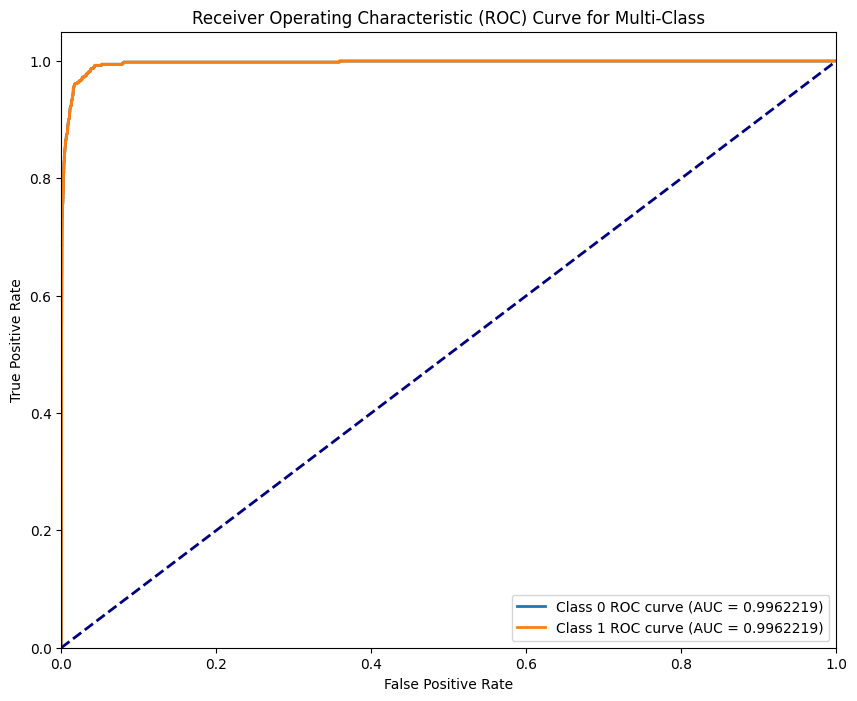

In [423]:
# AUC and ROC curves FOR TRAINING DATA
y_prob = model1.predict(X_test_processed)

plot_roc(y_test_sampled, y_prob)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 789us/step


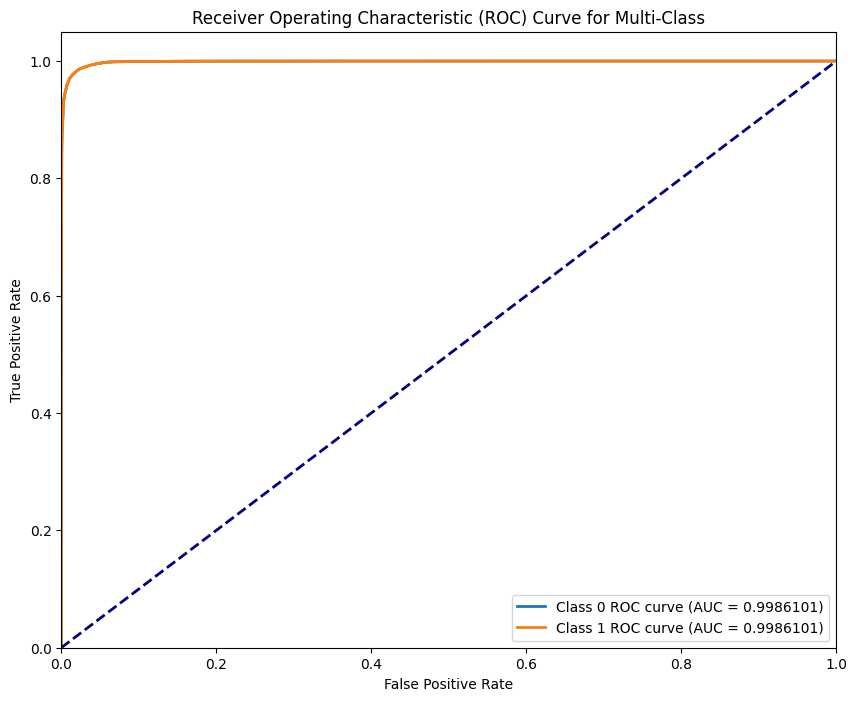

In [424]:
# AUC and ROC curves FOR TRAINING DATA
y_prob = model1.predict(X_train_processed)

plot_roc(y_train_sampled, y_prob)

In [430]:
# Assuming your model is named `model1`
model1.save('DNN_predicting_validated_parking.keras')


In [439]:
np.save('X_train_processed.npy', X_train_processed)
np.save('X_test_processed.npy', X_test_processed)


The model is performing well on train as well as test data with good AUC score for both classes. The precision, recall and F1 score is very different for both classes. This could be because of the huge class imbalance 19000 to 500 data points for class 0 and 1.

#### GLOBAL Interpretability

In [9]:
from tensorflow.keras.models import load_model
import shap
model = load_model('DNN_predicting_validated_parking.keras')

X_train_processed = np.load('X_train_processed.npy')
X_test_processed = np.load('X_test_processed.npy')

def f(X):
    return model.predict(X).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


Using 5000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 449us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 8s 487us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 443us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 440us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 449us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 448us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 448us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 448us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 446us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 444us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 7s 448us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
15625/15625 ━━━━━━━━━━━━━━━

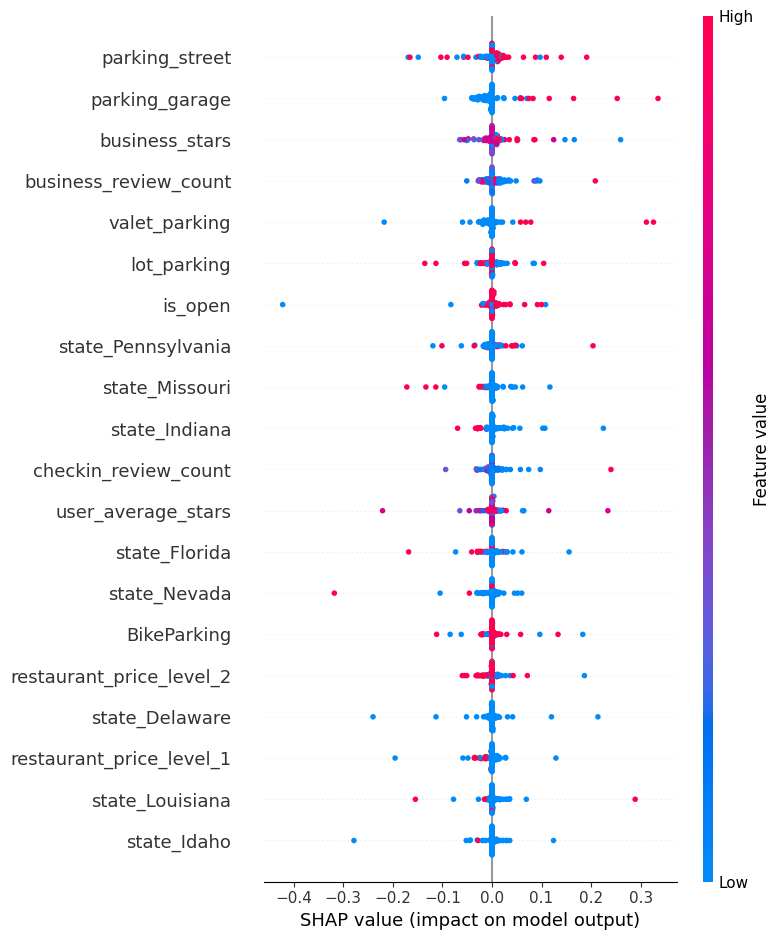

In [12]:
explainer = shap.KernelExplainer(f, X_train_processed[:5000])
all_feature_names = ['business_stars', 'business_review_count', 'is_open', 'BusinessAcceptsCreditCards', 'BikeParking', 
                    'parking_garage', 'parking_street', 'lot_parking', 'valet_parking', 'review_stars', 'review_useful', 
                    'review_funny', 'review_cool', 'user_review_count', 'user_average_stars', 'checkin_review_count', 
                    'state_Alberta', 'state_Arizona', 'state_California', 'state_Delaware', 'state_Florida', 'state_Idaho', 
                    'state_Illinois', 'state_Indiana', 'state_Louisiana', 'state_Missouri', 'state_Nevada', 'state_New Jersey', 
                    'state_Pennsylvania', 'state_Tennessee', 'restaurant_price_level_0', 'restaurant_price_level_1', 
                    'restaurant_price_level_2', 'restaurant_price_level_3', 'restaurant_price_level_4']


shap_values = explainer.shap_values(X_test_processed[:100], nsamples=100)
shap.summary_plot(shap_values, X_test_processed[:100], feature_names=all_feature_names)
# plt.savefig('shap_summary_plot.jpg')

SHAP Summary Plot: This is a global explanation that shows the overall importance of each feature across all the predictions in the dataset. It ranks features by their average impact on the model’s predictions and shows how the feature values affect the model output (higher or lower predictions).

### LOCAL Interpretability

In [15]:
import shap
shap.initjs()

In [16]:
explainer = shap.KernelExplainer(f, X_train_processed[:5000])
shap_values = explainer.shap_values(X_test_processed[:1], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values[0], X_test_processed[0])



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


Using 5000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 36s 463us/step


SHAP Force Plot: This is a local explanation that visualizes the contribution of each feature to the prediction for a specific instance. It shows how much each feature pushes the prediction higher or lower from the base value 

In [17]:
shap.save_html('force_plot.html', shap.force_plot(explainer.expected_value, shap_values[0], X_test_processed[0]))